# @title
### EP2 MAC0417 / MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,#
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO #
# DESTE EP. #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM #
# DESONESTIDADE ACADÊMICA OU PLÁGIO. #
# #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP. #
# #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR #
# DESONESTIDADE ACADÊMICA. #
# #
# #
# Nome : Patrícia da Silva Rodrigues #
# NUSP : 11315590 #
# Turma: MAC0417 #
# Prof.: Ronaldo Fumio Hashimoto #
##################################################################

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2


### Histograma médio de cada uma das iluminações para o originalGrayDataset

In [43]:
# Função para calcular o histograma médio usando a biblioteca cv2
def calculate_mean_histogram(images):
    histograms = []
    for image in images:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        histograms.append(hist)
    mean_histogram = np.mean(histograms, axis=0)
    return mean_histogram


In [44]:
# Função para plotar histogramas
def plot_histograms(histograms, title, y_limit=None):
    plt.figure(figsize=(12, 6))
    for key, hist in histograms.items():
        plt.plot(hist, label=key)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    if y_limit is not None:
        plt.ylim(0, y_limit)
    plt.show()

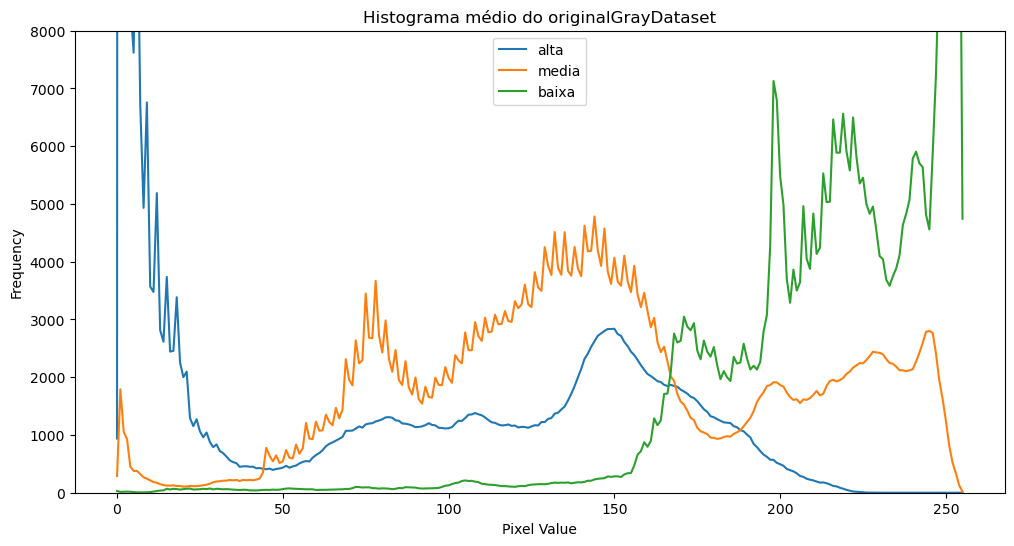

In [45]:

metadata = pd.read_csv('Metadados_gray_image/metadados_gray_image.csv') # Substitua pelo caminho correto do arquivo CSV

base_dir = 'originalGrayDataset'

iluminacoes = {'alta': [], 'media': [], 'baixa': []}

# Ler e processar cada imagem de acordo com os metadados
for index, row in metadata.iterrows():
    iluminacao = row['iluminacao']
    caminho_imagem = os.path.join(base_dir, row['fundo'], row['iluminacao'], row['nome_imagem'])
    grayscale_image = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    if grayscale_image is not None:
        iluminacoes[iluminacao].append(grayscale_image)

# Calcular o histograma médio para cada classe de iluminação
mean_histograms_augmented = {
    key: calculate_mean_histogram(images)
    for key, images in iluminacoes.items()
}

y_limit = 8000 

#adiciona um limite em y para aparecer no grafico porque, por algum motivo que eu nao consegui identificar, 
# a frequencia de alguns valores fica muito alta e isso distorceu muito o histograma 


plot_histograms(mean_histograms_augmented, 'Histograma médio do originalGrayDataset', y_limit)


### Histograma médio do augmented dataset antes das transformacoes

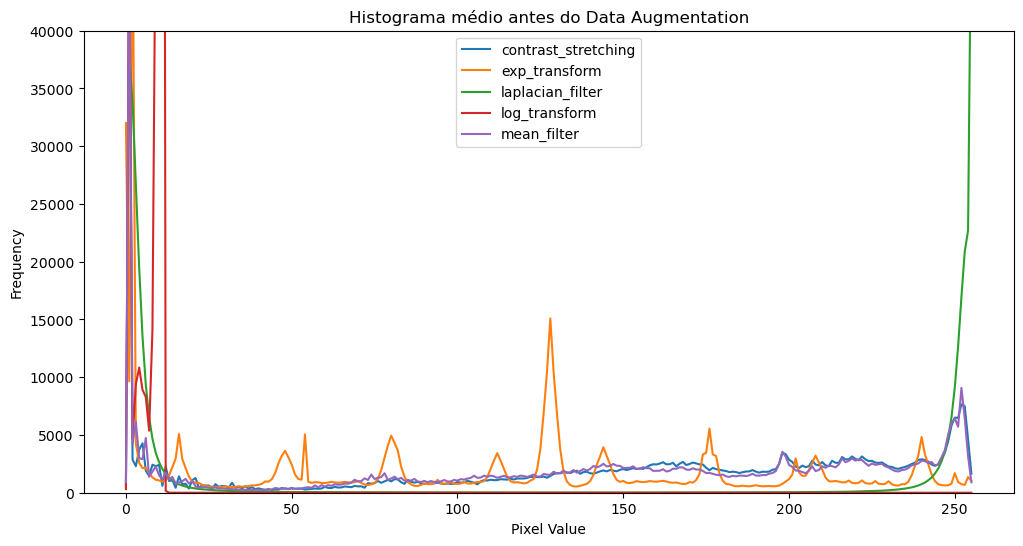

In [46]:



metadata = pd.read_csv('Metadados_Augmented_Data/metadados_augmented.csv') # Substitua pelo caminho correto do arquivo CSV

base_dir = 'augmentedDataset'
images_by_transformation = {'contrast_stretching': [], 'exp_transform': [], 'laplacian_filter': [], 'log_transform': [], 'mean_filter': []}

# Ler e processar cada imagem de acordo com os metadados
for index, row in metadata.iterrows():
    transformation = row['filtro']
    caminho_imagem = os.path.join(base_dir, row['filtro'], row['fundo'], row['iluminacao'], row['nome_imagem'])
    grayscale_image = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    if grayscale_image is not None:
        images_by_transformation[transformation].append(grayscale_image)

# Calcular o histograma médio para cada classe de iluminação
mean_histograms_augmented = {
    key: calculate_mean_histogram(images)
    for key, images in images_by_transformation.items()
}



y_limit = 40000 #adiciona um limite em y para aparecer no grafico porque, por algum motivo que eu nao consegui identificar, 
# a frequencia de alguns valores fica muito alta e isso distorceu muito o histograma 


plot_histograms(mean_histograms_augmented, 'Histograma médio antes do Data Augmentation', y_limit)


## Gerando o normalizedDataset

In [47]:
def mapeiaPixelNormalizado(imagem_original, data):
    nova_imagem = np.zeros_like(imagem_original)
    for i, valor in enumerate(data['Valor']):
        nova_imagem[imagem_original == valor] = data['Normalização'].iloc[i]
    
    return nova_imagem

In [48]:
def valCont(imagem_original):
    return np.unique(imagem_original, return_counts=True)

In [49]:
def normalizar_histograma(valores, contagem):
    if len(contagem) == 0:
        
        raise ValueError("Input contagem cannot be empty.")
    
    soma_cumulativa = np.cumsum(contagem)
    min_soma = np.min(soma_cumulativa)
    max_soma = np.max(soma_cumulativa)
    normalizacao = 255 * (soma_cumulativa - min_soma) / (max_soma - min_soma)
    
    data = pd.DataFrame({
        'Valor': valores,
        'Contagem': contagem,
        'Soma Cumulativa': soma_cumulativa,
        'Normalização': normalizacao.astype(int)
    })
    
    return data



In [50]:
################################ CELULA QUE FOI EXCLUIDA SEM QUERER QUE GERA O DATASET DAS IMAGENS NORMALIZADAS E O SEU CSV COM METADADOS ###############################

import csv

base_dir = 'augmentedDataset'
new_base_dir = 'normalizedDataset'
csv_path = 'Metadados_Augmented_Data/metadados_augmented.csv'

metadata = pd.read_csv(csv_path)


if not os.path.exists(new_base_dir):
    os.makedirs(new_base_dir)

metadados_normalizedDataset_image = []

for index, row in metadata.iterrows():
    caminho_imagem = os.path.join(base_dir, row['filtro'] ,row['fundo'], row['iluminacao'], row['nome_imagem'])
    grayscale_image = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    if grayscale_image is None:
        print(f"Erro: Não foi possível ler a imagem {caminho_imagem}")
        continue

    valores, contagem = valCont(grayscale_image)

    data_normalizada = normalizar_histograma(valores, contagem)

    normalized_image = mapeiaPixelNormalizado(grayscale_image, data_normalizada)

    output_dir = os.path.join(new_base_dir, row['filtro'] ,row['fundo'], row['iluminacao'])

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_image_path = os.path.join(output_dir, row['nome_imagem'])
    cv2.imwrite(output_image_path, normalized_image)

    metadados_normalizedDataset_image.append({
        'nome_imagem': row['nome_imagem'],
        'iluminacao': row['iluminacao'],
        'fundo': row['fundo'],
        'filtro': row['filtro']
    })

csv_filename = 'Metadados_Normalized/metadados_normalizedDataset.csv'
os.makedirs(os.path.dirname(csv_filename), exist_ok=True)

fieldnames = ['nome_imagem', 'fundo', 'iluminacao', 'filtro']

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for metadados in metadados_normalizedDataset_image:
        writer.writerow(metadados)

print(f"Dados escritos no arquivo {csv_filename}!")

Dados escritos no arquivo Metadados_Normalized/metadados_normalizedDataset.csv!


### Gerando o histograma médio após a normalizacao do augmented dataset (normalizedDataset)

histograma

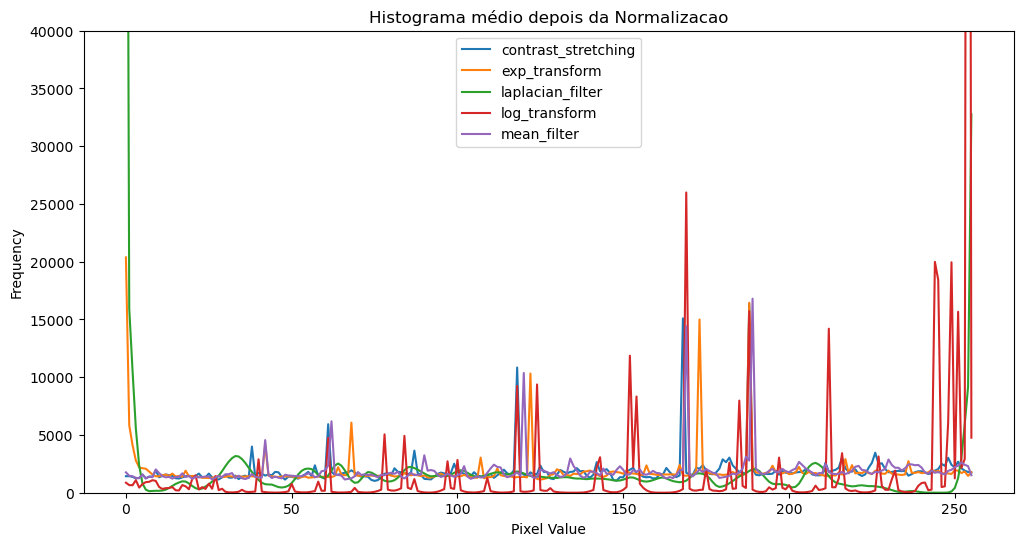

In [51]:

metadata = pd.read_csv('Metadados_Normalized/metadados_normalizedDataset.csv') 

base_dir = 'normalizedDataset'
images_by_transformation = {'contrast_stretching': [], 'exp_transform': [], 'laplacian_filter': [], 'log_transform': [], 'mean_filter': []}


for index, row in metadata.iterrows():
    transformation = row['filtro']
    caminho_imagem = os.path.join(base_dir, row['filtro'], row['fundo'], row['iluminacao'], row['nome_imagem'])
    grayscale_image = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    if grayscale_image is not None:
        images_by_transformation[transformation].append(grayscale_image)

# Calcular o histograma médio para cada classe de iluminação
mean_histograms_augmented = {
    key: calculate_mean_histogram(images)
    for key, images in images_by_transformation.items()
}



y_limit = 40000 #adiciona um limite em y para aparecer no grafico porque, por algum motivo que eu nao consegui identificar, 
# a frequencia de alguns valores fica muito alta e isso distorceu muito o histograma 


plot_histograms(mean_histograms_augmented, 'Histograma médio depois da Normalizacao', y_limit)


Imagens antes e depois 

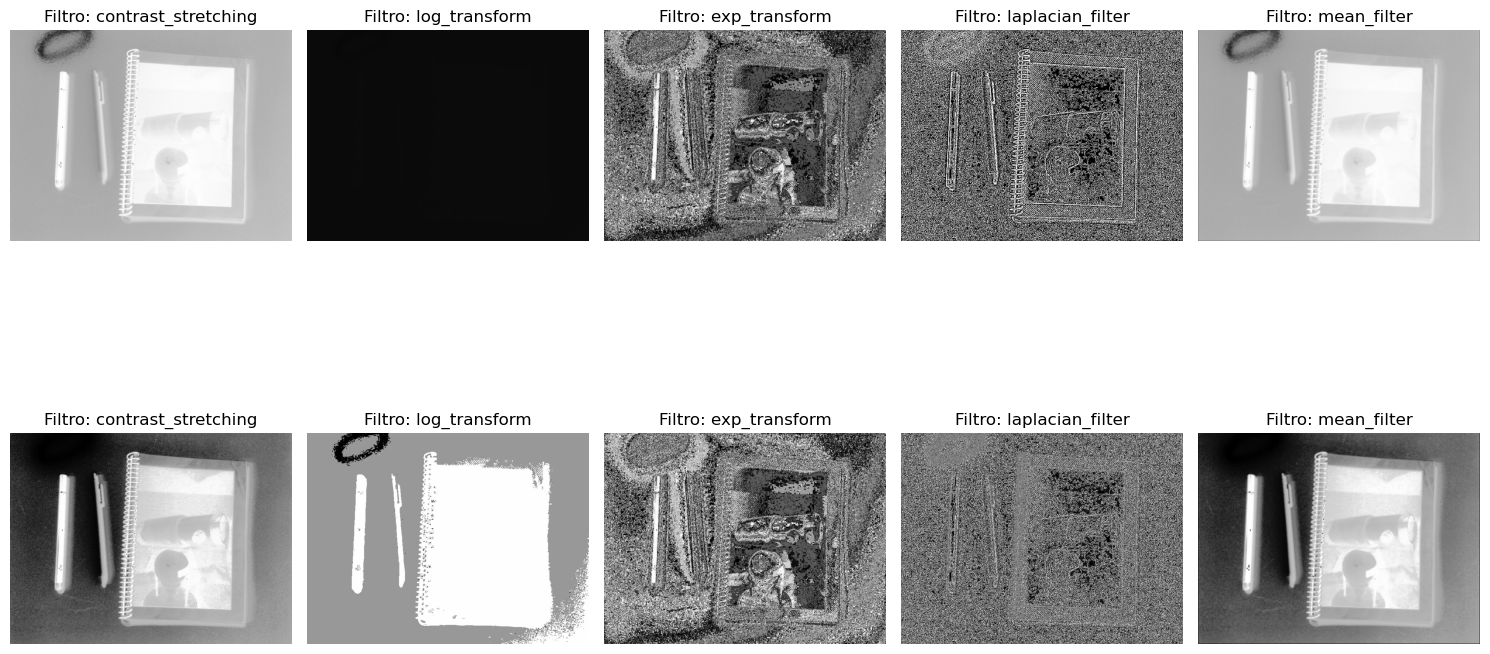

In [52]:

base_dir_augmented = 'augmentedDataset'
base_dir_normalized = 'normalizedDataset'

csv_file_augmented = 'Metadados_Augmented_Data/metadados_augmented.csv'
csv_file_normalized = 'Metadados_Normalized/metadados_normalizedDataset.csv'


df_augmented = pd.read_csv(csv_file_augmented)
df_normalized = pd.read_csv(csv_file_normalized)


caminhos_por_filtro_augmented = {}
caminhos_por_filtro_normalized = {}

# Percorre o dataa do conjunto de dados aumentado
for index, row in df_augmented.iterrows():
    caminho_imagem = os.path.join(base_dir_augmented, row['filtro'], row['fundo'], row['iluminacao'], row['nome_imagem'])
    filtro = row['filtro']
    
    # Verifica se o filtro já foi encontrado
    if filtro not in caminhos_por_filtro_augmented:
        caminhos_por_filtro_augmented[filtro] = caminho_imagem

# Percorre o data do conjunto de dados normalizado
for index, row in df_normalized.iterrows():
    caminho_imagem = os.path.join(base_dir_normalized, row['filtro'], row['fundo'], row['iluminacao'], row['nome_imagem'])
    filtro = row['filtro']
    
    # Verifica se o filtro já foi encontrado. Se nao foi, registra
    if filtro not in caminhos_por_filtro_normalized:
        caminhos_por_filtro_normalized[filtro] = caminho_imagem

# Plotar as imagens lado a lado (antes) e em baixo tambem lado a lado (depois)
num_filtros = len(caminhos_por_filtro_augmented)
fig, axs = plt.subplots(2, num_filtros, figsize=(15, 10))

for i, (filtro, caminho) in enumerate(caminhos_por_filtro_augmented.items()):
    imagem_augmented = cv2.imread(caminho)
    if imagem_augmented is not None:
        imagem_augmented_rgb = cv2.cvtColor(imagem_augmented, cv2.COLOR_BGR2RGB)
        axs[0, i].imshow(imagem_augmented_rgb)
        axs[0, i].set_title(f"Filtro: {filtro}")
        axs[0, i].axis('off')
        
    else:
        print(f"Não foi possível carregar a imagem aumentada: {caminho}")

for i, (filtro, caminho) in enumerate(caminhos_por_filtro_normalized.items()):
    imagem_normalized = cv2.imread(caminho)
    if imagem_normalized is not None:
        imagem_normalized_rgb = cv2.cvtColor(imagem_normalized, cv2.COLOR_BGR2RGB)
        axs[1, i].imshow(imagem_normalized_rgb)
        axs[1, i].set_title(f"Filtro: {filtro}")
        axs[1, i].axis('off')
        
    else:
        print(f"Não foi possível carregar a imagem normalizada: {caminho}")

plt.tight_layout()
plt.show()


### comentários: 


Podemos observar que no geral as imagens ficaram mais lavadas

A aplicação da equalização de histograma para normalizar as imagens levou a uma distribuição de intensidade mais equilibrada e melhorou o contraste, destacando, assim, os detalhes das imagens.

No histograma médio do gray dataset, observamos que a luminosidade baixa apresentou maiores valores de intensidade mais escuros, a intensidade média ficou melhor distribuida e a alta apresentou valores mais altos de intensidades claras.

Antes da normalização, 'log' nao dava para ver quase nada, após, pude verbem melhor o que estava na imagem, isso sugere que a imagem ficou mais lavada.

'laplacian' foi suavisada, mas ainda com pontos escuros. 

O filtro Laplaciano e o log, apesar da imagem ficar mais lavada, ainda apresentam um pico de valores de intensidade escuros

